In [1]:
# Core libraries and model APIs
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier



In [2]:
def clean_data(df: pd.DataFrame):
    """
    Cleans the input dataframe by:
    1. Removing empty rows and columns.
    2. Keeping only the specified features and the target.
    3. Removing duplicate rows.
    4. Dropping rows with missing target values.
    5. Splitting into features (X) and target (y).
    
    Args:
        df (pd.DataFrame): The raw dataframe.
    
    Returns:
        tuple: (X, y) where
            X (pd.DataFrame): Feature dataframe (restricted to chosen features).
            y (pd.Series): Target column ('NSP').
    """
    # Step 1: Make a working copy of the dataframe
    cleaned = df.copy()
    
    # Step 2: Drop any rows or columns that are completely empty
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    
    # Step 3: Define target and allowed features
    target_col = 'NSP'
    allowed_features = {
        'b', 'e', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR', 'LB',
        'ASTV', 'MSTV', 'ALTV', 'MLTV',
        'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode',
        'Median', 'Variance', 'Tendency'
    }
    
    # Step 4: Keep only allowed features + target (with validation)
    available_features = [c for c in allowed_features if c in cleaned.columns]
    
    # Warn if target column is missing
    if target_col not in cleaned.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")
    
    # Warn about missing features (optional but helpful)
    missing_features = allowed_features - set(available_features)
    if missing_features:
        print(f"Warning: The following features are missing: {missing_features}")
    
    keep_cols = available_features + [target_col]
    cleaned = cleaned[keep_cols]
    
    # Step 5: Remove duplicate rows
    cleaned = cleaned.drop_duplicates()
    
    # Step 6: Drop rows where target is missing
    cleaned = cleaned.dropna(subset=[target_col])
    
    # Step 7: Handle missing values in features (optional - you might want to impute)
    # For now, dropping rows with any missing feature values
    initial_rows = len(cleaned)
    cleaned = cleaned.dropna()
    dropped_rows = initial_rows - len(cleaned)
    if dropped_rows > 0:
        print(f"Dropped {dropped_rows} rows with missing feature values")
    
    # Step 8: Separate features and target
    X = cleaned.drop(columns=[target_col])
    y = cleaned[target_col]

    # Add at the end before returning:
    # Reset index to avoid gaps after dropping rows
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    print(f"Final dataset: {len(X)} samples, {len(X.columns)} features")
    
    return X, y

In [3]:
df = pd.read_excel('ctg.xlsx', sheet_name = 'Data', header = 1)
df

,b,e,AC,FM,UC,DL,DS,DP,DR,Unnamed: 9,...,E,AD,DE,LD,FS,SUSP,Unnamed: 42,CLASS,Unnamed: 44,NSP
0,240.0,357.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,NaN,9.0,NaN,2.0
1,5.0,632.0,4.0,0.0,4.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
2,177.0,779.0,2.0,0.0,5.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
3,411.0,1192.0,2.0,0.0,6.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
4,533.0,1147.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,2.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1576.0,3049.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,NaN,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,5.0,NaN,2.0
2125,2796.0,3415.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,1.0,NaN,1.0
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,...,72.0,332.0,252.0,107.0,69.0,197.0,NaN,NaN,NaN,NaN


In [4]:
X, y = clean_data(df)

Final dataset: 2115 samples, 23 features


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import lightgbm as lgb


def evaluate_with_smote_cv_lightgbm_optimal2(
    X, y, 
    test_size=0.2, 
    n_splits=5, 
    random_state=42,
    use_early_stopping=True,
    early_stopping_rounds=50,
    use_class_weights=False,
    smote_strategy='auto',
    verbose=True
):
    """
    Enhanced LightGBM training with SMOTE + Stratified K-Fold CV.
    
    Args:
        X (pd.DataFrame): Feature matrix
        y (pd.Series): Target column
        test_size (float): Proportion for test split
        n_splits (int): Number of folds for cross-validation
        random_state (int): Random seed
        use_early_stopping (bool): Whether to use early stopping for final model
        early_stopping_rounds (int): Number of rounds for early stopping
        use_class_weights (bool): Use class_weight='balanced' instead of/with SMOTE
        smote_strategy (str): SMOTE sampling strategy ('auto', 'not majority', 'all')
        verbose (bool): Print detailed output
    
    Returns:
        dict: Contains model, scores, splits, and diagnostics
    """
    # --- 1. Train/test split with stratification ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    
    if verbose:
        print("=" * 60)
        print("TRAINING CONFIGURATION")
        print("=" * 60)
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        print(f"Class distribution (train): {dict(y_train.value_counts().sort_index())}")
        print(f"Class distribution (test): {dict(y_test.value_counts().sort_index())}")
        print()
    
    # --- 2. Best parameters from Optuna (Trial 27) ---
    best_params = {
        'learning_rate': 0.09518867841433679,
        'num_leaves': 27,
        'max_depth': 12,
        'min_child_samples': 26,
        'min_split_gain': 0.0637337805202833,
        'lambda_l1': 0.6089094114371527,
        'lambda_l2': 1.2021507701921763,
        'feature_fraction': 0.8839452483534593,
        'bagging_fraction': 0.8166691612094572,
        'bagging_freq': 6,
        'extra_trees': False,
        'n_estimators': 800,
        'objective': 'multiclass',
        'num_class': 3,
        'random_state': random_state,
        'n_jobs': -1,
        'verbose': -1
    }
    
    # Add class weights if requested
    if use_class_weights:
        best_params['class_weight'] = 'balanced'
        if verbose:
            print("Using class_weight='balanced'")
    
    # --- 3. Stratified CV evaluation with SMOTE ---
    if verbose:
        print("=" * 60)
        print("CROSS-VALIDATION EVALUATION")
        print("=" * 60)
    
    pipeline = Pipeline(steps=[
        ('smote', SMOTE(random_state=random_state, sampling_strategy=smote_strategy)),
        ('lgbm', LGBMClassifier(**best_params))
    ])
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scorer = make_scorer(balanced_accuracy_score)
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring=scorer, n_jobs=-1)
    
    if verbose:
        print(f"Balanced Accuracy per fold: {np.round(scores, 4)}")
        print(f"Mean Balanced Accuracy: {np.round(np.mean(scores), 4)} ± {np.round(np.std(scores), 4)}")
        print()
    
    # --- 4. Train final model with SMOTE applied on training set ---
    if verbose:
        print("=" * 60)
        print("FINAL MODEL TRAINING")
        print("=" * 60)
    
    smote = SMOTE(random_state=random_state, sampling_strategy=smote_strategy)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    
    if verbose:
        print(f"After SMOTE - Train size: {len(X_train_bal)}")
        print(f"Class distribution (balanced): {dict(pd.Series(y_train_bal).value_counts().sort_index())}")
        print()
    
    model = LGBMClassifier(**best_params)
    
    # Fit with or without early stopping
    if use_early_stopping:
        callbacks = [lgb.early_stopping(early_stopping_rounds, verbose=False)]
        model.fit(
            X_train_bal, y_train_bal,
            eval_set=[(X_test, y_test)],
            callbacks=callbacks
        )
        if verbose and hasattr(model, 'best_iteration_'):
            print(f"Best iteration: {model.best_iteration_} (out of {best_params['n_estimators']})")
    else:
        model.fit(X_train_bal, y_train_bal)
    
    # --- 5. Feature importance ---
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # --- 6. Test set evaluation ---
    y_pred = model.predict(X_test)
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    if verbose:
        print(f"\nTest Set Balanced Accuracy: {np.round(test_balanced_acc, 4)}")
        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_pred))
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))
        print("=" * 60)
    
    # --- 7. Return comprehensive results ---
    return {
        'model': model,
        'cv_scores': scores,
        'cv_mean': np.mean(scores),
        'cv_std': np.std(scores),
        'test_balanced_accuracy': test_balanced_acc,
        'feature_importance': feature_importance,
        'splits': {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        },
        'balanced_train_shape': X_train_bal.shape,
        'predictions': y_pred,
        'hyperparameters': best_params
    }


# Example usage:
"""
results = evaluate_with_smote_cv_lightgbm_optimal(
    X, y,
    test_size=0.2,
    n_splits=5,
    random_state=42,
    use_early_stopping=True,
    early_stopping_rounds=50,
    use_class_weights=False,
    verbose=True
)

# Access components
model = results['model']
cv_scores = results['cv_scores']
feature_importance = results['feature_importance']
X_train, X_test = results['splits']['X_train'], results['splits']['X_test']
y_train, y_test = results['splits']['y_train'], results['splits']['y_test']
"""

"\nresults = evaluate_with_smote_cv_lightgbm_optimal(\n    X, y,\n    test_size=0.2,\n    n_splits=5,\n    random_state=42,\n    use_early_stopping=True,\n    early_stopping_rounds=50,\n    use_class_weights=False,\n    verbose=True\n)\n\n# Access components\nmodel = results['model']\ncv_scores = results['cv_scores']\nfeature_importance = results['feature_importance']\nX_train, X_test = results['splits']['X_train'], results['splits']['X_test']\ny_train, y_test = results['splits']['y_train'], results['splits']['y_test']\n"

In [6]:
results = evaluate_with_smote_cv_lightgbm_optimal2(
    X, y,
    test_size=0.2,
    n_splits=5,
    random_state=42,
    use_early_stopping=True,
    early_stopping_rounds=50,
    use_class_weights=False,
    verbose=True
)

TRAINING CONFIGURATION
Train size: 1692, Test size: 423
Class distribution (train): {1.0: 1318, 2.0: 234, 3.0: 140}
Class distribution (test): {1.0: 329, 2.0: 59, 3.0: 35}

CROSS-VALIDATION EVALUATION
Balanced Accuracy per fold: [0.8706 0.8769 0.9176 0.9032 0.8997]
Mean Balanced Accuracy: 0.8936 ± 0.0174

FINAL MODEL TRAINING
After SMOTE - Train size: 3954
Class distribution (balanced): {1.0: 1318, 2.0: 1318, 3.0: 1318}

Best iteration: 78 (out of 800)

Test Set Balanced Accuracy: 0.9307

Classification Report (Test Set):
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98       329
         2.0       0.89      0.86      0.88        59
         3.0       1.00      0.94      0.97        35

    accuracy                           0.96       423
   macro avg       0.96      0.93      0.94       423
weighted avg       0.96      0.96      0.96       423


Top 10 Most Important Features:
 feature  importance
    ASTV         602
    ALTV        

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

class FeatureSelector:
    """
    Comprehensive feature selection using multiple strategies:
    - Top-K selection
    - Backward ablation
    - Stability across random seeds
    - Permutation importance validation
    """
    
    def __init__(self, model_class, model_params=None):
        """
        Args:
            model_class: Model class (e.g., RandomForestClassifier)
            model_params: Dict of model parameters
        """
        self.model_class = model_class
        self.model_params = model_params or {}
        self.results = {}
        
    def evaluate_feature_set(self, X: pd.DataFrame, y: pd.Series, 
                            features: List[str], cv_folds: int = 5,
                            random_state: int = 42) -> Dict:
        """
        Evaluate a specific feature set using cross-validation.
        
        Returns:
            Dict with mean/std of balanced accuracy
        """
        X_subset = X[features]
        
        model = self.model_class(**self.model_params, random_state=random_state)
        
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        scorer = make_scorer(balanced_accuracy_score)
        
        scores = cross_val_score(model, X_subset, y, cv=cv, scoring=scorer, n_jobs=-1)
        
        return {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores,
            'features': features
        }
    
    def top_k_sweep(self, X: pd.DataFrame, y: pd.Series,
                    feature_rankings: List[str],
                    k_values: List[int] = [5, 8, 10, 12, 15, 20],
                    n_seeds: int = 3) -> pd.DataFrame:
        """
        Test different numbers of top features.
        
        Args:
            X: Feature dataframe
            y: Target series
            feature_rankings: Features ordered by importance (best first)
            k_values: Numbers of features to test
            n_seeds: Number of random seeds for stability
        """
        print("=" * 70)
        print("TOP-K FEATURE SWEEP")
        print("=" * 70)
        
        results = []
        
        for k in k_values:
            if k > len(feature_rankings):
                continue
                
            top_k_features = feature_rankings[:k]
            print(f"\nTesting Top-{k} features: {top_k_features[:5]}...")
            
            seed_scores = []
            for seed in range(42, 42 + n_seeds):
                result = self.evaluate_feature_set(X, y, top_k_features, 
                                                   random_state=seed)
                seed_scores.append(result['mean'])
            
            mean_across_seeds = np.mean(seed_scores)
            std_across_seeds = np.std(seed_scores)
            
            results.append({
                'k': k,
                'features': ', '.join(top_k_features[:3]) + '...',
                'balanced_acc_mean': mean_across_seeds,
                'balanced_acc_std': std_across_seeds,
                'stability': std_across_seeds  # Lower is more stable
            })
            
            print(f"  → Balanced Accuracy: {mean_across_seeds:.4f} ± {std_across_seeds:.4f}")
        
        results_df = pd.DataFrame(results)
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.errorbar(results_df['k'], results_df['balanced_acc_mean'], 
                    yerr=results_df['balanced_acc_std'], 
                    marker='o', capsize=5, linewidth=2, markersize=8)
        plt.xlabel('Number of Features (K)', fontsize=12)
        plt.ylabel('Balanced Accuracy', fontsize=12)
        plt.title('Top-K Feature Performance', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('top_k_sweep.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n{'='*70}")
        print("TOP-K RESULTS SUMMARY")
        print('='*70)
        print(results_df.to_string(index=False))
        
        # Find best K
        best_idx = results_df['balanced_acc_mean'].idxmax()
        best_k = results_df.loc[best_idx, 'k']
        best_score = results_df.loc[best_idx, 'balanced_acc_mean']
        print(f"\n✓ Best K: {best_k} features (Balanced Acc: {best_score:.4f})")
        
        self.results['top_k'] = results_df
        return results_df
    
    def backward_ablation(self, X: pd.DataFrame, y: pd.Series,
                         baseline_features: List[str],
                         core_features: List[str],
                         threshold_drop: float = 0.005,
                         n_seeds: int = 3) -> Dict:
        """
        Drop features one at a time to see impact.
        Only drop if removal doesn't hurt performance significantly.
        
        Args:
            X: Feature dataframe
            y: Target series
            baseline_features: Starting feature set
            core_features: Features to NEVER drop
            threshold_drop: Max acceptable drop in balanced accuracy
            n_seeds: Number of seeds for stability
        """
        print("\n" + "=" * 70)
        print("BACKWARD ABLATION (Drop One at a Time)")
        print("=" * 70)
        print(f"Core features (protected): {core_features}")
        print(f"Threshold: Drop feature if removal causes < {threshold_drop:.3f} decrease\n")
        
        # Get baseline performance
        print("Establishing baseline with all features...")
        baseline_scores = []
        for seed in range(42, 42 + n_seeds):
            result = self.evaluate_feature_set(X, y, baseline_features, random_state=seed)
            baseline_scores.append(result['mean'])
        baseline_mean = np.mean(baseline_scores)
        
        print(f"Baseline (all {len(baseline_features)} features): {baseline_mean:.4f}\n")
        
        # Test dropping each non-core feature
        candidates_to_drop = [f for f in baseline_features if f not in core_features]
        
        ablation_results = []
        
        for feature in candidates_to_drop:
            reduced_features = [f for f in baseline_features if f != feature]
            
            drop_scores = []
            for seed in range(42, 42 + n_seeds):
                result = self.evaluate_feature_set(X, y, reduced_features, random_state=seed)
                drop_scores.append(result['mean'])
            
            drop_mean = np.mean(drop_scores)
            drop_std = np.std(drop_scores)
            impact = baseline_mean - drop_mean
            
            decision = "DROP" if impact < threshold_drop else "KEEP"
            
            ablation_results.append({
                'feature': feature,
                'without_score': drop_mean,
                'impact': impact,
                'std': drop_std,
                'decision': decision
            })
            
            status = "✗" if decision == "DROP" else "✓"
            print(f"{status} {feature:12s} → {drop_mean:.4f} (Δ {impact:+.4f}) → {decision}")
        
        ablation_df = pd.DataFrame(ablation_results).sort_values('impact', ascending=False)
        
        # Recommended feature set
        features_to_keep = core_features + [
            row['feature'] for _, row in ablation_df.iterrows() 
            if row['decision'] == 'KEEP'
        ]
        
        features_to_drop = [
            row['feature'] for _, row in ablation_df.iterrows() 
            if row['decision'] == 'DROP'
        ]
        
        print(f"\n{'='*70}")
        print("ABLATION RECOMMENDATIONS")
        print('='*70)
        print(f"✓ Keep ({len(features_to_keep)}): {features_to_keep}")
        print(f"✗ Drop ({len(features_to_drop)}): {features_to_drop}")
        
        # Visualize impact
        plt.figure(figsize=(10, 8))
        colors = ['red' if d == 'DROP' else 'green' for d in ablation_df['decision']]
        plt.barh(range(len(ablation_df)), ablation_df['impact'], color=colors, alpha=0.6)
        plt.yticks(range(len(ablation_df)), ablation_df['feature'])
        plt.axvline(x=threshold_drop, color='black', linestyle='--', 
                   label=f'Threshold ({threshold_drop:.3f})')
        plt.xlabel('Impact of Removal (Higher = More Important)', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Backward Ablation: Feature Importance', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.savefig('backward_ablation.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        self.results['ablation'] = {
            'dataframe': ablation_df,
            'keep': features_to_keep,
            'drop': features_to_drop,
            'baseline': baseline_mean
        }
        
        return self.results['ablation']
    
    def stability_check(self, X: pd.DataFrame, y: pd.Series,
                       feature_set: List[str],
                       n_trials: int = 10) -> pd.DataFrame:
        """
        Check stability of feature set across multiple random seeds.
        """
        print("\n" + "=" * 70)
        print(f"STABILITY CHECK ({n_trials} random seeds)")
        print("=" * 70)
        
        trial_scores = []
        for trial in range(n_trials):
            seed = 42 + trial
            result = self.evaluate_feature_set(X, y, feature_set, random_state=seed)
            trial_scores.append(result['mean'])
            print(f"Trial {trial+1:2d} (seed={seed}): {result['mean']:.4f}")
        
        mean_score = np.mean(trial_scores)
        std_score = np.std(trial_scores)
        cv_score = (std_score / mean_score) * 100  # Coefficient of variation
        
        print(f"\n{'='*70}")
        print(f"Mean Balanced Accuracy: {mean_score:.4f} ± {std_score:.4f}")
        print(f"Coefficient of Variation: {cv_score:.2f}%")
        
        if cv_score < 1.0:
            print("✓ Very stable feature set!")
        elif cv_score < 2.0:
            print("✓ Reasonably stable")
        else:
            print("⚠ High variability - consider feature engineering")
        
        stability_df = pd.DataFrame({
            'trial': range(1, n_trials + 1),
            'seed': range(42, 42 + n_trials),
            'balanced_accuracy': trial_scores
        })
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(stability_df['trial'], stability_df['balanced_accuracy'], 
                marker='o', linewidth=2, markersize=8)
        plt.axhline(y=mean_score, color='red', linestyle='--', 
                   label=f'Mean: {mean_score:.4f}')
        plt.fill_between(stability_df['trial'], 
                        mean_score - std_score, 
                        mean_score + std_score,
                        alpha=0.2, color='red', label=f'±1 SD')
        plt.xlabel('Trial', fontsize=12)
        plt.ylabel('Balanced Accuracy', fontsize=12)
        plt.title('Stability Across Random Seeds', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('stability_check.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        self.results['stability'] = stability_df
        return stability_df
    
    def permutation_importance_check(self, X: pd.DataFrame, y: pd.Series,
                                    features: List[str],
                                    n_repeats: int = 10) -> pd.DataFrame:
        """
        Cross-validate feature importance using permutation.
        """
        from sklearn.inspection import permutation_importance
        
        print("\n" + "=" * 70)
        print("PERMUTATION IMPORTANCE (Cross-validation)")
        print("=" * 70)
        
        X_subset = X[features]
        model = self.model_class(**self.model_params, random_state=42)
        model.fit(X_subset, y)
        
        # Permutation importance
        perm_result = permutation_importance(
            model, X_subset, y,
            n_repeats=n_repeats,
            random_state=42,
            scoring='balanced_accuracy',
            n_jobs=-1
        )
        
        perm_df = pd.DataFrame({
            'feature': features,
            'importance_mean': perm_result.importances_mean,
            'importance_std': perm_result.importances_std
        }).sort_values('importance_mean', ascending=False)
        
        print(perm_df.to_string(index=False))
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(perm_df)), perm_df['importance_mean'], 
                xerr=perm_df['importance_std'], alpha=0.6, capsize=5)
        plt.yticks(range(len(perm_df)), perm_df['feature'])
        plt.xlabel('Permutation Importance (Balanced Accuracy)', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Permutation Importance Validation', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.savefig('permutation_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        self.results['permutation'] = perm_df
        return perm_df
    
    def full_pipeline(self, X: pd.DataFrame, y: pd.Series,
                     shap_ranking: List[str],
                     core_features: List[str]) -> Dict:
        """
        Run complete feature selection pipeline.
        
        Args:
            X: Full feature dataframe
            y: Target series
            shap_ranking: Features ranked by SHAP importance
            core_features: Must-keep features
        """
        print("\n" + "🔍" * 35)
        print("COMPREHENSIVE FEATURE SELECTION PIPELINE")
        print("🔍" * 35)
        
        # 1. Top-K Sweep
        k_values = [5, 8, 10, 12, 15, len(shap_ranking)]
        top_k_results = self.top_k_sweep(X, y, shap_ranking, k_values=k_values)
        
        # 2. Backward Ablation
        best_k_idx = top_k_results['balanced_acc_mean'].idxmax()
        best_k = int(top_k_results.loc[best_k_idx, 'k'])
        baseline_features = shap_ranking[:best_k]
        
        ablation_results = self.backward_ablation(
            X, y, baseline_features, core_features, threshold_drop=0.005
        )
        
        # 3. Stability Check
        recommended_features = ablation_results['keep']
        stability_results = self.stability_check(X, y, recommended_features, n_trials=10)
        
        # 4. Permutation Importance
        perm_results = self.permutation_importance_check(X, y, recommended_features)
        
        # Final summary
        print("\n" + "=" * 70)
        print("🎯 FINAL RECOMMENDATIONS")
        print("=" * 70)
        print(f"Original features: {len(X.columns)}")
        print(f"Recommended features: {len(recommended_features)}")
        print(f"Features to drop: {len(X.columns) - len(recommended_features)}")
        print(f"\n✓ Final feature set ({len(recommended_features)}):")
        for i, feat in enumerate(recommended_features, 1):
            print(f"   {i:2d}. {feat}")
        
        print(f"\n✗ Features to drop ({len(ablation_results['drop'])}):")
        print(f"   {', '.join(ablation_results['drop'])}")
        
        return {
            'recommended_features': recommended_features,
            'dropped_features': ablation_results['drop'],
            'all_results': self.results
        }


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

"""
# Define your feature groups based on SHAP analysis
CORE_FEATURES = ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']

SHAP_RANKING = [
    'ASTV', 'DP', 'ALTV', 'Median', 'Variance',  # Top tier
    'Mode', 'UC', 'MLTV', 'AC', 'Nmax',  # Second tier
    'LB', 'Width', 'MSTV', 'Tendency', 'FM', 'e', 'Min', 'Max', 'DL', 'DS', 'DR', 'b', 'Nzeros'  # Candidates to drop
]

# Initialize selector with your model
from sklearn.ensemble import RandomForestClassifier

selector = FeatureSelector(
    model_class=RandomForestClassifier,
    model_params={'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
)

# Run full pipeline
final_results = selector.full_pipeline(
    X=X_train,  # Your training features
    y=y_train,  # Your training targets
    shap_ranking=SHAP_RANKING,
    core_features=CORE_FEATURES
)

# Get recommended features
best_features = final_results['recommended_features']

# Train final model with selected features
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train[best_features], y_train)

# Evaluate on test set
from sklearn.metrics import balanced_accuracy_score
y_pred = final_model.predict(X_test[best_features])
final_score = balanced_accuracy_score(y_test, y_pred)
print(f"\nFinal Test Balanced Accuracy: {final_score:.4f}")
"""

'\n# Define your feature groups based on SHAP analysis\nCORE_FEATURES = [\'ASTV\', \'DP\', \'ALTV\', \'Median\', \'Variance\']\n\nSHAP_RANKING = [\n    \'ASTV\', \'DP\', \'ALTV\', \'Median\', \'Variance\',  # Top tier\n    \'Mode\', \'UC\', \'MLTV\', \'AC\', \'Nmax\',  # Second tier\n    \'LB\', \'Width\', \'MSTV\', \'Tendency\', \'FM\', \'e\', \'Min\', \'Max\', \'DL\', \'DS\', \'DR\', \'b\', \'Nzeros\'  # Candidates to drop\n]\n\n# Initialize selector with your model\nfrom sklearn.ensemble import RandomForestClassifier\n\nselector = FeatureSelector(\n    model_class=RandomForestClassifier,\n    model_params={\'n_estimators\': 100, \'max_depth\': 10, \'class_weight\': \'balanced\'}\n)\n\n# Run full pipeline\nfinal_results = selector.full_pipeline(\n    X=X_train,  # Your training features\n    y=y_train,  # Your training targets\n    shap_ranking=SHAP_RANKING,\n    core_features=CORE_FEATURES\n)\n\n# Get recommended features\nbest_features = final_results[\'recommended_features\']\n\n#


🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
COMPREHENSIVE FEATURE SELECTION PIPELINE
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
TOP-K FEATURE SWEEP

Testing Top-5 features: ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']...
  → Balanced Accuracy: 0.8570 ± 0.0045

Testing Top-8 features: ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']...
  → Balanced Accuracy: 0.8625 ± 0.0047

Testing Top-10 features: ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']...
  → Balanced Accuracy: 0.8876 ± 0.0026

Testing Top-12 features: ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']...
  → Balanced Accuracy: 0.8780 ± 0.0054

Testing Top-15 features: ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']...
  → Balanced Accuracy: 0.8785 ± 0.0030

Testing Top-23 features: ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']...
  → Balanced Accuracy: 0.8801 ± 0.0020


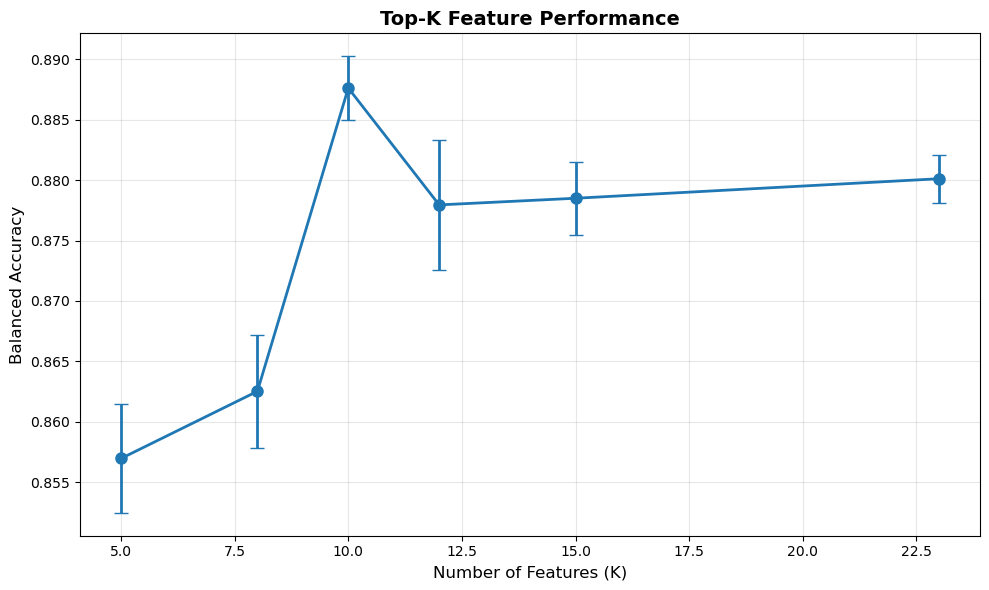


TOP-K RESULTS SUMMARY
 k          features  balanced_acc_mean  balanced_acc_std  stability
 5 ASTV, DP, ALTV...           0.856960          0.004505   0.004505
 8 ASTV, DP, ALTV...           0.862523          0.004680   0.004680
10 ASTV, DP, ALTV...           0.887630          0.002640   0.002640
12 ASTV, DP, ALTV...           0.877955          0.005361   0.005361
15 ASTV, DP, ALTV...           0.878506          0.003002   0.003002
23 ASTV, DP, ALTV...           0.880123          0.002001   0.002001

✓ Best K: 10 features (Balanced Acc: 0.8876)

BACKWARD ABLATION (Drop One at a Time)
Core features (protected): ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']
Threshold: Drop feature if removal causes < 0.005 decrease

Establishing baseline with all features...
Baseline (all 10 features): 0.8876

✓ Mode         → 0.8808 (Δ +0.0068) → KEEP
✓ UC           → 0.8803 (Δ +0.0073) → KEEP
✗ MLTV         → 0.8890 (Δ -0.0014) → DROP
✓ AC           → 0.8677 (Δ +0.0200) → KEEP
✗ Nmax         → 0.8897 (

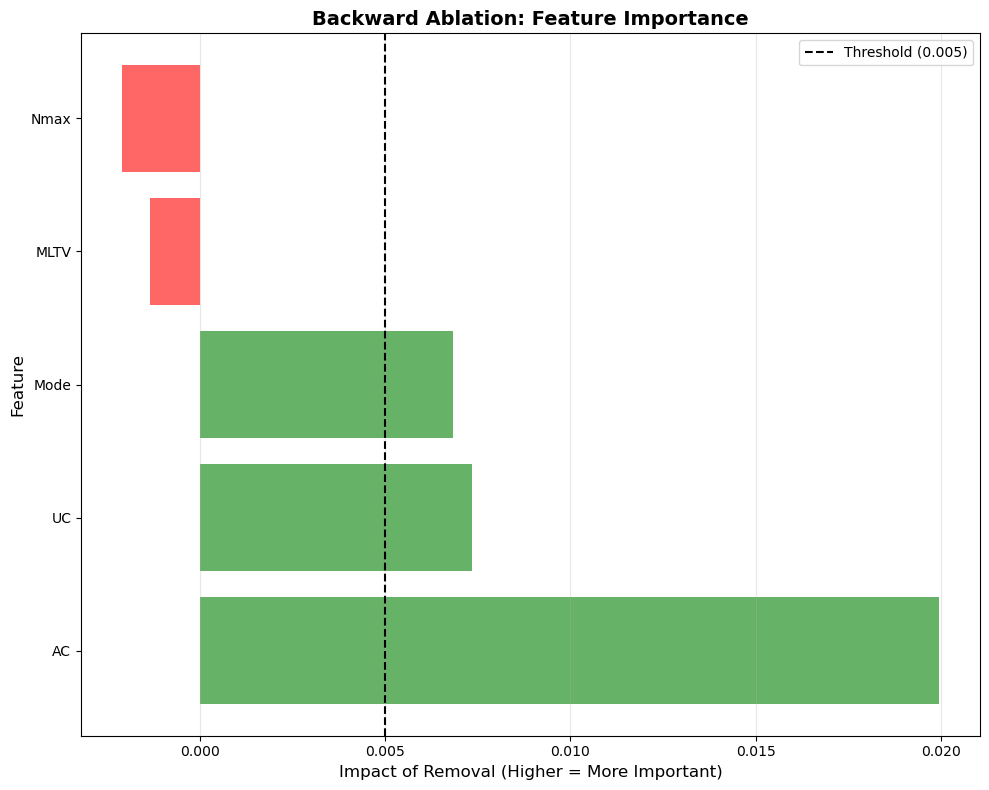


STABILITY CHECK (10 random seeds)
Trial  1 (seed=42): 0.8886
Trial  2 (seed=43): 0.8975
Trial  3 (seed=44): 0.8888
Trial  4 (seed=45): 0.8778
Trial  5 (seed=46): 0.8829
Trial  6 (seed=47): 0.8884
Trial  7 (seed=48): 0.8841
Trial  8 (seed=49): 0.8796
Trial  9 (seed=50): 0.8814
Trial 10 (seed=51): 0.8836

Mean Balanced Accuracy: 0.8853 ± 0.0054
Coefficient of Variation: 0.61%
✓ Very stable feature set!


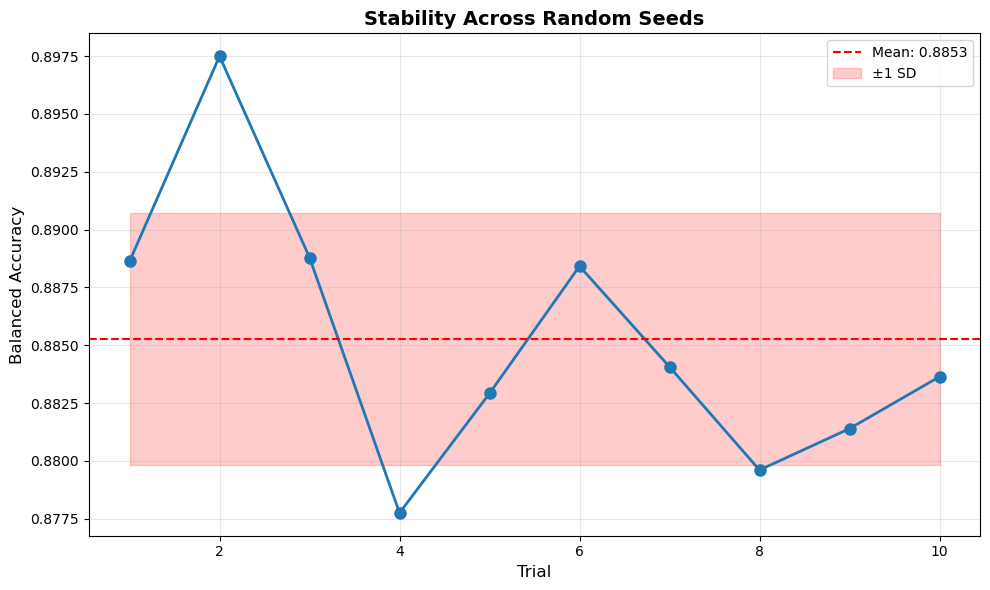


PERMUTATION IMPORTANCE (Cross-validation)
 feature  importance_mean  importance_std
    ASTV         0.236275        0.014160
      AC         0.215667        0.011938
  Median         0.156474        0.008592
    ALTV         0.152051        0.005993
      DP         0.085577        0.003096
Variance         0.085478        0.006743
    Mode         0.082649        0.010719
      UC         0.063143        0.003102


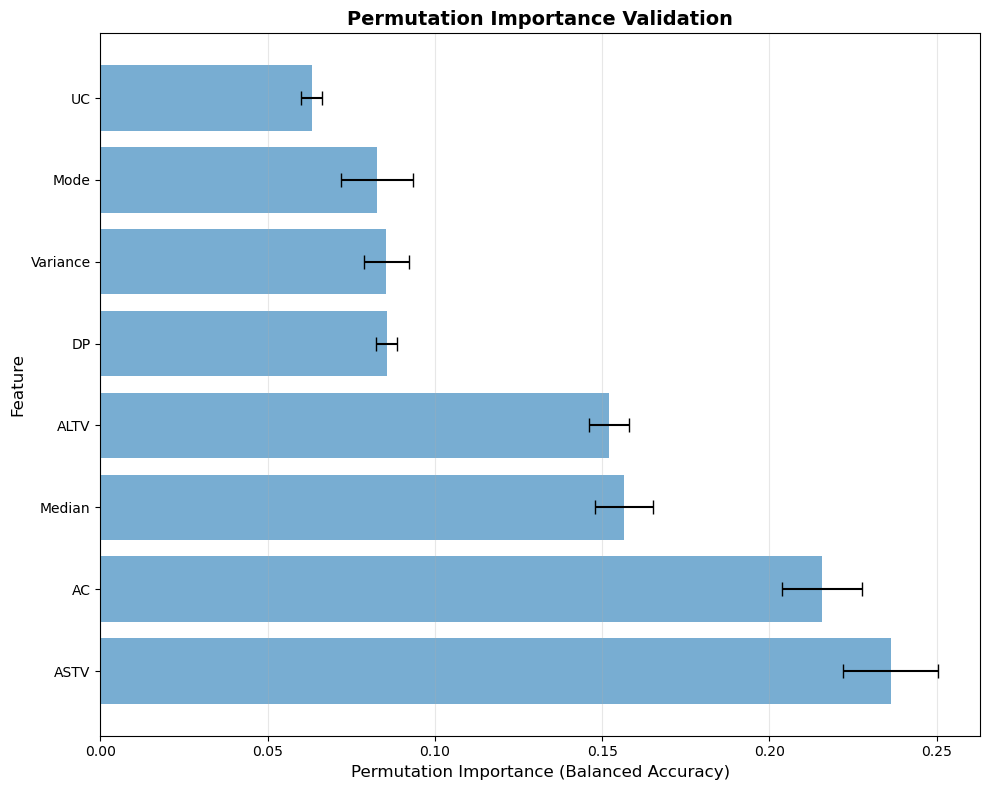


🎯 FINAL RECOMMENDATIONS
Original features: 23
Recommended features: 8
Features to drop: 15

✓ Final feature set (8):
    1. ASTV
    2. DP
    3. ALTV
    4. Median
    5. Variance
    6. AC
    7. UC
    8. Mode

✗ Features to drop (2):
   MLTV, Nmax


NameError: name 'X_train' is not defined

In [8]:

# Define your feature groups based on SHAP analysis
CORE_FEATURES = ['ASTV', 'DP', 'ALTV', 'Median', 'Variance']

SHAP_RANKING = [
    'ASTV', 'DP', 'ALTV', 'Median', 'Variance',  # Top tier
    'Mode', 'UC', 'MLTV', 'AC', 'Nmax',  # Second tier
    'LB', 'Width', 'MSTV', 'Tendency', 'FM', 'e', 'Min', 'Max', 'DL', 'DS', 'DR', 'b', 'Nzeros'  # Candidates to drop
]

# Initialize selector with your model
from sklearn.ensemble import RandomForestClassifier

selector = FeatureSelector(
    model_class=RandomForestClassifier,
    model_params={'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
)

# Run full pipeline
final_results = selector.full_pipeline(
    X=results['splits']['X_train'],  # Your training features
    y=results['splits']['y_train'],  # Your training targets
    shap_ranking=SHAP_RANKING,
    core_features=CORE_FEATURES
)

# Get recommended features
best_features = final_results['recommended_features']

# Train final model with selected features
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train[best_features], y_train)

# Evaluate on test set
from sklearn.metrics import balanced_accuracy_score
y_pred = final_model.predict(X_test[best_features])
final_score = balanced_accuracy_score(y_test, y_pred)
print(f"\nFinal Test Balanced Accuracy: {final_score:.4f}")


In [ ]:
# X_train, X_test = results['splits']['X_train'], results['splits']['X_test']
# y_train, y_test = results['splits']['y_train'], results['splits']['y_test']